In [1]:

from numpy import random
import torch
import torchvision
from torch.nn import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import cv2
import os
import tensorflow as tf
from tensorflow import keras
import scipy.stats as sci 

2023-10-15 10:03:25.145735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 10:03:32.537445: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /scratch/shkulkar/python/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.3/lib64:/scratch/shkulkar/python/lib:/usr/local/cuda-11.3/tensorRT-8.0/lib64:/usr/local/cuda-11.3/cudnn-8.2/lib64:/usr/local/cuda-11.3/nccl-2.9/lib64
2023-10-15 10:03:32.537791: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.

In [2]:
import torch

print(torch.__version__)


1.12.1+cu113


In [3]:
os.environ['HTTP_PROXY'] = 'http://fp.cs.ovgu.de:3210/'
os.environ['HTTPS_PROXY'] = 'http://fp.cs.ovgu.de:3210/'
# !git clone https://github.com/yiskw713/ScoreCAM.git

In [4]:
%cd /project/validating_attribution_techniques/commons/ScoreCAM

/project/validating_attribution_techniques/commons/ScoreCAM


In [5]:
!nvidia-smi


Sun Oct 15 10:03:44 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:B1:00.0 Off |                  N/A |
| 22%   24C    P8               6W / 250W |      1MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:

os.environ['CUDA_VISIBLE_DEVICES'] = "2,3"
ngpu = torch.cuda.device_count()
for gpu_id in range(ngpu):
    gpu = torch.cuda.get_device_name(gpu_id)
    print(f"GPU:{gpu_id} {gpu}")

GPU:0 NVIDIA GeForce RTX 2080 Ti
GPU:1 NVIDIA GeForce RTX 2080 Ti


In [7]:
%matplotlib inline

import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
# from ScoreCAM import cam

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
from utils.visualize import visualize, reverse_normalize
from utils.imagenet_labels import label2idx, idx2label

from scipy.spatial.distance import cdist
from pyemd import emd


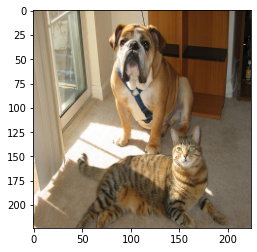

In [8]:
image = Image.open('/project/validating_attribution_techniques/commons/examples/input.png')
# image = keras.utils.get_file("cat_and_dog.jpg", "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",)
imshow(image)

In [9]:

# Resize the image
size = (300, 300)
image = image.resize(size)

In [10]:
# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

# convert image to tensor
tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)

In [11]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.eval()

Using cache found in /home/shkulkar/.cache/torch/hub/pytorch_vision_v0.10.0
/scratch/shkulkar/python/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/scratch/shkulkar/python/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
gpu_reference_tensor = next(model.parameters())
tensor = tensor.type_as(gpu_reference_tensor)

In [13]:
target_layer = model.layer4[1].conv2
wrapped_model = ScoreCAM(model, target_layer)
cam, idx = wrapped_model(tensor)

In [14]:
classes = open("/project/validating_attribution_techniques/shardul/classes.txt").read().splitlines()

243


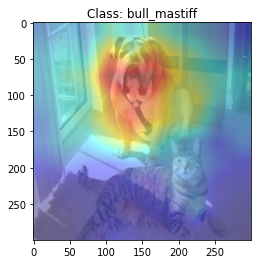

In [15]:
fig, ax = plt.subplots()
print(idx)
img = reverse_normalize(tensor)
heatmap = visualize(img, cam)
heatmap = np.transpose(heatmap.squeeze(), (1, 2, 0))
ax.imshow(heatmap, cmap='turbo', alpha = 0.8)
ax.set_title(f"Class: {classes[idx]}")
fig.savefig(f"/project/validating_attribution_techniques/shardul/output/saliency/before_noise/{idx2label[idx]}.jpeg")

In [16]:
##Adding Noise iteratively

# def perturb_image(image, saliency_map, perturbation_strength=0.05, saliency_threshold=0.5, num_iterations=1, perturbation_prob=0.1):
#     # Get the top n percent of saliency values
#     saliency_values = saliency_map.view(-1)
#     threshold = torch.kthvalue(saliency_values, int((1 - saliency_threshold) * saliency_values.size(0)) + 1).values
    
#     # Threshold the saliency map and generate a mask
#     mask = torch.gt(saliency_map, threshold).float()
    
#     # Perturb the image for a given number of iterations only at a random subset of the mask where the value is 1
#     perturbed_image = image.clone()
#     for i in range(num_iterations):
#         perturbation_mask = (mask == 1) * (torch.rand_like(mask) > perturbation_prob).float()
#         noise = torch.randn_like(image) * perturbation_strength
#         perturbed_image = perturbed_image + perturbation_mask * noise
#         perturbed_image = torch.clamp(perturbed_image, 0, 1)
        
#     return perturbed_image

def perturb_image(image, saliency_map, perturbation_strength=0.05, saliency_threshold=0.5, num_iterations=1, perturbation_prob=0.1):
    """perturbation_strength: This parameter controls the strength of the perturbation applied to the image. 
    It determines the magnitude of the noise added to the image.
    
    saliency_threshold: This parameter determines the percentage of saliency values to consider as the top values.
    It is used to threshold the saliency map and generate a binary mask.
    
    num_iterations: This parameter specifies the number of iterations to perturb the image. In each iteration, 
    the perturbation is applied to the image based on the saliency mask.
    
    perturbation_prob: This parameter controls the probability of perturbing each pixel in the saliency mask.
    It determines the randomness of the perturbation."""
    
    # Move the image tensor to the device of the saliency_map tensor
    image = image.to(saliency_map.device)
    
    # Get the top n percent of saliency values
    saliency_values = saliency_map.view(-1)
    threshold = torch.kthvalue(saliency_values, int((1 - saliency_threshold) * saliency_values.size(0)) + 1).values
    
    # Threshold the saliency map and generate a mask
    mask = torch.gt(saliency_map, threshold).float()
    
    # Perturb the image for a given number of iterations only at a random subset of the mask where the value is 1
    perturbed_image = image.clone()
    for i in range(num_iterations):
        perturbation_mask = (mask == 1) * (torch.rand_like(mask) < perturbation_prob).float()
        noise = torch.randn_like(perturbed_image) * perturbation_strength
        perturbation_mask = perturbation_mask.to(perturbed_image.device)  # Move perturbation_mask to the same device as perturbed_image
        noise = noise.to(perturbed_image.device)  # Move noise to the same device as perturbed_image
        perturbed_image = perturbed_image + perturbation_mask * noise
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        
    return perturbed_image


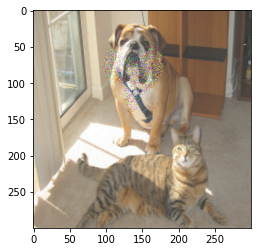

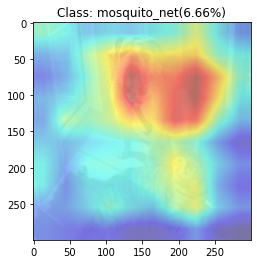

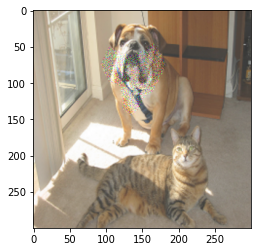

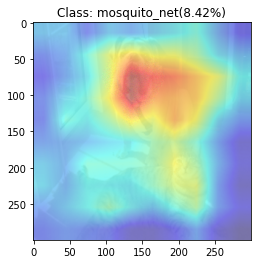

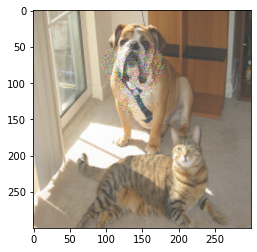

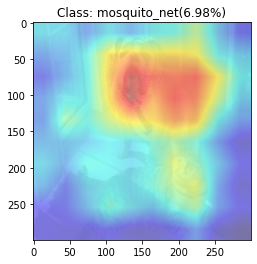

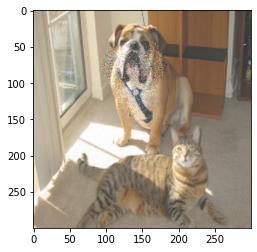

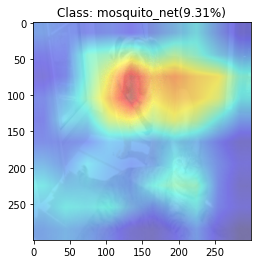

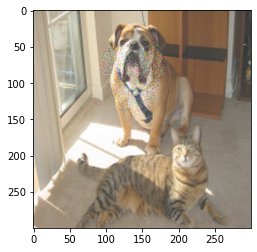

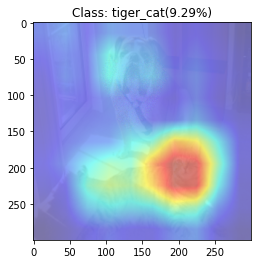

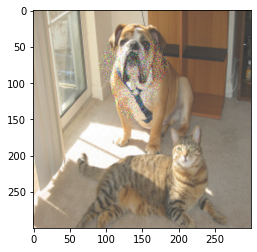

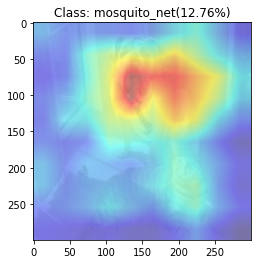

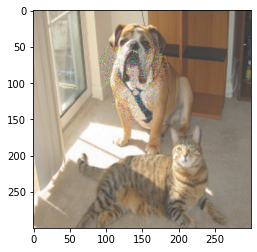

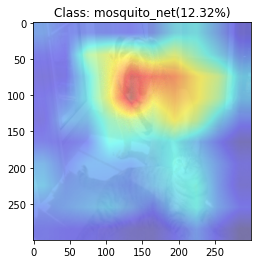

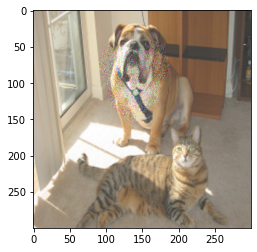

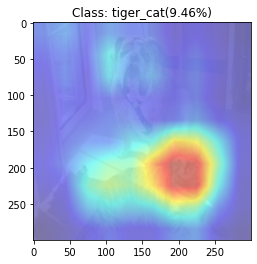

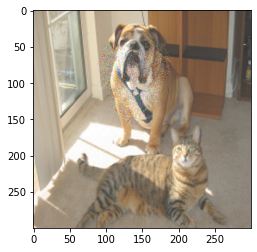

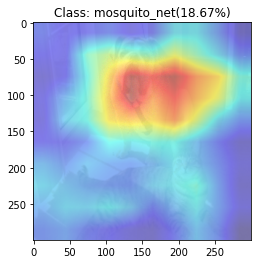

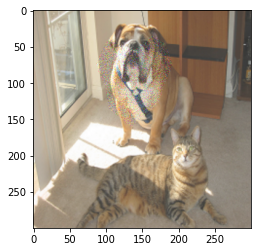

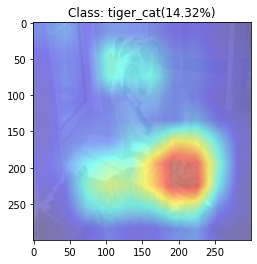

In [17]:
saliency_threshold = 0.05
perturbation_strength = 0.2
perturbation_prob = 0.9
for i in range(10):

  # perturbed_tensor = perturb_image(tensor, saliency_map, saliency_map < perturbation_strength, saliency_threshold)
  perturbed_tensor = perturb_image(tensor, cam, perturbation_strength, saliency_threshold, 1, perturbation_prob)


  # import matplotlib.pyplot as plt
  # Convert the tensor to a numpy array
  image_array = perturbed_tensor.squeeze().permute(1,2,0).detach().cpu().numpy()

  #Normalize the array to [0, 1]
  image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))
  fig, ax = plt.subplots()
  # Show the image using matplotlib
  ax.imshow(image_array, cmap = 'turbo', alpha = 0.8)
#   ax.set_title(f"Class: {idx2label[idx]}")
  fig.savefig(f"/project/validating_attribution_techniques/shardul/output/noisy_images/{i}_noise.jpeg")
  
  perturbation_strength -= 0.01
  saliency_threshold += 0.005

  fig, ax = plt.subplots()
  # img = tf.keras.preprocessing.image.load_img(f'/content/output/noise/9_noise'+'.jpeg')
  # perturbed_tensor = preprocess(img) # converting image to tensor
  # perturbed_tensor = tensor.unsqueeze(0)
  perturbed_tensor = perturbed_tensor.type_as(gpu_reference_tensor)
  saliency_map_perturbed, perturbed_idx = wrapped_model(perturbed_tensor)
  with torch.no_grad():
    output = model(perturbed_tensor)
    perturbed_class = torch.argmax(output).item()
    prob = torch.softmax(output, dim=1)[0, perturbed_class].item()
  img = reverse_normalize(perturbed_tensor)
  heatmap = visualize(img, saliency_map_perturbed)
  hm = (heatmap.squeeze().numpy().transpose(1, 2, 0))
  ax.imshow(hm, cmap='turbo', alpha = 0.8)
  ax.set_title(f"Class: {classes[perturbed_idx]}({prob*100:.2f}%)")
  fig.savefig(f"/project/validating_attribution_techniques/shardul/output/saliency/after_noise/{i}_{idx2label[idx]}.jpeg")

  # saliency_threshold -= 0.02
  # perturbation_strength -= 0.006


plt.show()

In [ ]:
#Creating the patch
PATCH_SIZE = 60
def apply_grey_patch(path, image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = 0
    img = keras.preprocessing.image.array_to_img(patched_image)
    print(path)
    img.save(path)
    print(np.shape(patched_image))
    return patched_image

In [ ]:
#Putting the patch over the image
#Putting the patch over the image
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)


i = 0
# Iterate the patch over the image
for top_left_x in range(0, image.shape[0], PATCH_SIZE):
    for top_left_y in range(0, image.shape[1], PATCH_SIZE):
        # Apply the patch and display the image
        path = '/home/shkulkar/project/validating_attribution_techniques/shardul/output/noisy_images/occlusion/occluded_img_'+str(i)+'.jpg'
        i+=1
        patched_image = apply_grey_patch(path,image, top_left_x, top_left_y, PATCH_SIZE)
        patched_image = patched_image.astype('float32') / 255.0

In [ ]:
#Metrics

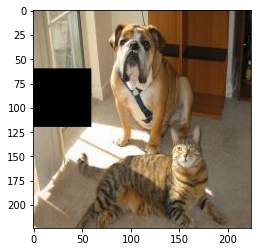

In [17]:
perturbed_image = Image.open('/home/shkulkar/project/validating_attribution_techniques/shardul/output/noisy_images/occlusion/occluded_img_1.jpg')
imshow(perturbed_image)

In [19]:
# Resize the image
size = (300, 300)
perturbed_image = perturbed_image.resize(size)
# convert image to tensor
perturbed_tensor = preprocess(perturbed_image)

# reshape 4D tensor (N, C, H, W)
perturbed_tensor = perturbed_tensor.unsqueeze(0)

gpu_reference_tensor = next(model.parameters())
perturbed_tensor = perturbed_tensor.type_as(gpu_reference_tensor)

wrapped_model = ScoreCAM(model, target_layer)
perturbed_cam, perturbed_idx = wrapped_model(perturbed_tensor)

In [28]:
# # img = tf.keras.preprocessing.image.load_img('/home/shkulkar/project/validating_attribution_techniques/shardul/output/noisy_images/occlusion/occluded_img_'+str(i)+'.jpg')
# img = tf.keras.preprocessing.image.load_img('/home/shkulkar/project/validating_attribution_techniques/shardul/output/noisy_images/occlusion/occluded_img_3.jpg')
# tensor = preprocess(img) # converting image to tensor
# # tensor = tensor.unsqueeze(0).to(device) # reshape 4D tensor (N, C, H, W); N:batch size, C: Channels, H: Height of tensor, W: Width of tensor
# tensor = tensor.unsqueeze(0)
# perturbed_cam, perturbed_idx = wrapped_model(tensor)



243


Text(0.5, 1.0, 'Class: bull_mastiff')

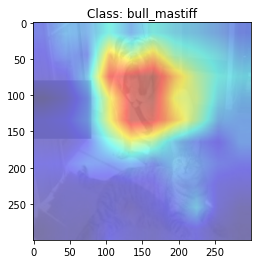

In [39]:
fig, ax = plt.subplots()
print(perturbed_idx)
perturbed_img = reverse_normalize(perturbed_tensor)
heatmap1 = visualize(perturbed_img, perturbed_cam)
heatmap1 = np.transpose(heatmap1.squeeze(), (1, 2, 0))
ax.imshow(heatmap1, cmap='turbo', alpha = 0.8)
ax.set_title(f"Class: {classes[perturbed_idx]}")



In [ ]:
#https://github.com/herrlich10/saliency/tree/master/benchmark

In [21]:
import numpy as np
from skimage import img_as_float
from skimage import exposure

def normalize(x, method='standard', axis=None):
    '''Normalizes the input with specified method.

    Parameters
    ----------
    x : array-like
    method : string, optional
        Valid values for method are:
        - 'standard': mean=0, std=1
        - 'range': min=0, max=1
        - 'sum': sum=1
    axis : int, optional
        Axis perpendicular to which array is sliced and normalized.
        If None, array is flattened and normalized.

    Returns
    -------
    res : numpy.ndarray
        Normalized array.
    '''
    # TODO: Prevent divided by zero if the map is flat
    x = np.array(x, copy=False)
    if axis is not None:
        y = np.rollaxis(x, axis).reshape([x.shape[axis], -1])
        shape = np.ones(len(x.shape))
        shape[axis] = x.shape[axis]
        if method == 'standard':
            res = (x - np.mean(y, axis=1).reshape(shape)) / np.std(y, axis=1).reshape(shape)
        elif method == 'range':
            res = (x - np.min(y, axis=1).reshape(shape)) / (np.max(y, axis=1) - np.min(y, axis=1)).reshape(shape)
        elif method == 'sum':
            res = x / np.float_(np.sum(y, axis=1).reshape(shape))
        else:
            raise ValueError('method not in {"standard", "range", "sum"}')
    else:
        if method == 'standard':
            res = (x - np.mean(x)) / np.std(x)
        elif method == 'range':
            res = (x - np.min(x)) / (np.max(x) - np.min(x))
        elif method == 'sum':
            res = x / float(np.sum(x))
        else:
            raise ValueError('method not in {"standard", "range", "sum"}')
    return res


def match_hist(image, cdf, bin_centers, nbins=256):
    '''Modify pixels of input image so that its histogram matches target image histogram, specified by:
    cdf, bin_centers = cumulative_distribution(target_image)

    Parameters
    ----------
    image : array
        Image to be transformed.
    cdf : 1D array
        Values of cumulative distribution function of the target histogram.
    bin_centers ; 1D array
        Centers of bins of the target histogram.
    nbins : int, optional
        Number of bins for image histogram.

    Returns
    -------
    out : float array
        Image array after histogram matching.

    References
    ----------
    [1] Matlab implementation histoMatch(MTX, N, X) by Simoncelli, 7/96.
    '''
    image = img_as_float(image)
    old_cdf, old_bin = exposure.cumulative_distribution(image, nbins) # Unlike [1], we didn't add small positive number to the histogram
    new_bin = np.interp(old_cdf, cdf, bin_centers)
    out = np.interp(image.ravel(), old_bin, new_bin)
    return out.reshape(image.shape)

In [31]:
from functools import partial
import numpy as np
from numpy import random
from skimage import exposure
from skimage.transform import resize
# from utils import normalize, match_hist


def EMD(saliency_map1, saliency_map2, sub_sample=1/2.0):
    map2 = np.array(saliency_map2, copy=False)
    # Reduce image size for efficiency of calculation
    map2 = resize(map2, np.round(np.array(map2.shape) * sub_sample), order=1, mode='constant')
    map1 = resize(saliency_map1, map2.shape, order=1, mode='constant')
    # Histogram match the images so they have the same mass
    map1 = match_hist(map1, *exposure.cumulative_distribution(map2))
    # Normalize the two maps to sum up to 1
    map1 = normalize(map1, method='sum')
    map2 = normalize(map2, method='sum')
    # Compute EMD with OpenCV
    r, c = map2.shape
    x, y = np.meshgrid(range(c), range(r))
    signature1 = cv2.CreateMat(r * c, 3, cv2.CV_32FC1)
    signature2 = cv2.CreateMat(r * c, 3, cv2.CV_32FC1)
    cv2.Convert(cv2.fromarray(np.c_[map1.ravel(), x.ravel(), y.ravel()]), signature1)
    cv2.Convert(cv2.fromarray(np.c_[map2.ravel(), x.ravel(), y.ravel()]), signature2)
    return cv2.CalcEMD2(signature2, signature1, cv2.CV_DIST_L2)


In [ ]:
def normalize_map(map):
    min_value = np.min(map)
    max_value = np.max(map)
    normalized_map = (map - min_value) / (max_value - min_value)
    return normalized_map


In [32]:
# saliency_map1 = normalize_map(np.array(cam))
# saliency_map2 = normalize_map(np.array(perturbed_cam))

saliency_map1 = np.array(cam)
saliency_map2 = np.array(perturbed_cam)


In [33]:
emd= EMD(saliency_map1, saliency_map2)

/scratch/shkulkar/python/lib/python3.8/site-packages/skimage/transform/_warps.py:160: RuntimeWarning: divide by zero encountered in divide
  factors = np.divide(input_shape, output_shape)


OverflowError: cannot convert float infinity to integer

In [ ]:
fig, ax = plt.subplots()

for i in range(0,15):
  img = tf.keras.preprocessing.image.load_img('/home/shkulkar/project/validating_attribution_techniques/shardul/output/noisy_images/occlusion/occluded_img_'+str(i)+'.jpg')
  tensor = preprocess(img) # converting image to tensor
  tensor = tensor.unsqueeze(0).to(device) # reshape 4D tensor (N, C, H, W); N:batch size, C: Channels, H: Height of tensor, W: Width of tensor
  perturbed_cam, idx = wrapped_model(tensor)
  print(idx2label[idx])
  img = reverse_normalize(tensor)
  heatmap = visualize(img, perturbed_cam)
  heatmap = np.transpose(heatmap.squeeze(), (1, 2, 0))
  ax.imshow(heatmap, cmap='turbo', alpha = 0.8)
  with torch.no_grad():
    output = model(tensor)
    perturbed_class = torch.argmax(output).item()
    prob = torch.softmax(output, dim=1)[0, perturbed_class].item()
  ax.set_title(f"Class: {idx2label[idx]}({prob*100:.2f}%)")
  score, flag = EMD(cam, perturbed_cam)
  print(score, flag)
  fig.savefig(f"/project/validating_attribution_techniques/shardul/output/saliency/after_noise/{i}_{idx2label[idx]}.jpg")
  #save_image(heatmap, '/content/drive/MyDrive/Deep Learning Projects/Fooling attribution techniques/Saliency_Map/'+str(i)+'_{}.jpeg'.format(idx2label[idx])) #.set_title(f"Class: {idx2label[idx]} ({prob*100:.2f}%)")
plt.show()

In [22]:
def SIM(saliency_map1, saliency_map2):
    '''
    Similarity between two different saliency maps when viewed as distributions
    (SIM=1 means the distributions are identical).

    This similarity measure is also called **histogram intersection**.

    Parameters
    ----------
    saliency_map1 : real-valued matrix
        If the two maps are different in shape, saliency_map1 will be resized to match saliency_map2.
    saliency_map2 : real-valued matrix

    Returns
    -------
    SIM : float, between [0,1]
    '''
    map1 = np.array(saliency_map1, copy=False)
    map2 = np.array(saliency_map2, copy=False)
    if map1.shape != map2.shape:
        map1 = resize(map1, map2.shape, order=3, mode='nearest') # bi-cubic/nearest is what Matlab imresize() does by default
    # Normalize the two maps to have values between [0,1] and sum up to 1
    map1 = normalize(map1, method='range')
    map2 = normalize(map2, method='range')
    map1 = normalize(map1, method='sum')
    map2 = normalize(map2, method='sum')
    # Compute histogram intersection
    intersection = np.minimum(map1, map2)
    return np.sum(intersection)

In [23]:
sim = SIM(cam, perturbed_cam)

In [24]:
print(sim)

0.8960498


In [25]:
def CC(saliency_map1, saliency_map2):
    '''
    Pearson's correlation coefficient between two different saliency maps
    (CC=0 for uncorrelated maps, CC=1 for perfect linear correlation).

    Parameters
    ----------
    saliency_map1 : real-valued matrix
        If the two maps are different in shape, saliency_map1 will be resized to match saliency_map2.
    saliency_map2 : real-valued matrix

    Returns
    -------
    CC : float, between [-1,1]
    '''
    map1 = np.array(saliency_map1, copy=False)
    map2 = np.array(saliency_map2, copy=False)
    if map1.shape != map2.shape:
        map1 = resize(map1, map2.shape, order=3, mode='nearest') # bi-cubic/nearest is what Matlab imresize() does by default
    # Normalize the two maps to have zero mean and unit std
    map1 = normalize(map1, method='standard')
    map2 = normalize(map2, method='standard')
    # Compute correlation coefficient
    return np.corrcoef(map1.ravel(), map2.ravel())[0,1]

In [26]:
cc = CC(cam, perturbed_cam)

In [27]:
print(cc)

0.9313637137355179


In [28]:
def NSS(saliency_map, fixation_map):
    '''
    Normalized scanpath saliency of a saliency map,
    defined as the mean value of normalized (i.e., standardized) saliency map at fixation locations.
    You can think of it as a z-score. (Larger value implies better performance.)

    Parameters
    ----------
    saliency_map : real-valued matrix
        If the two maps are different in shape, saliency_map will be resized to match fixation_map..
    fixation_map : binary matrix
        Human fixation map (1 for fixated location, 0 for elsewhere).

    Returns
    -------
    NSS : float, positive
    '''
    s_map = np.array(saliency_map, copy=False)
    f_map = np.array(fixation_map, copy=False) > 0.5
    if s_map.shape != f_map.shape:
        s_map = resize(s_map, f_map.shape)
    # Normalize saliency map to have zero mean and unit std
    s_map = normalize(s_map, method='standard')
    # Mean saliency value at fixation locations
    return np.mean(s_map[f_map])

In [29]:
nss = NSS(cam, perturbed_cam)

In [30]:
print(nss)

1.7053552


In [31]:
def AUC_Judd(saliency_map, fixation_map, jitter=True):
    '''
    AUC stands for Area Under ROC Curve.
    This measures how well the saliency map of an image predicts the ground truth human fixations on the image.

    ROC curve is created by sweeping through threshold values
    determined by range of saliency map values at fixation locations.
    True positive (tp) rate correspond to the ratio of saliency map values above threshold
    at fixation locations to the total number of fixation locations.
    False positive (fp) rate correspond to the ratio of saliency map values above threshold
    at all other locations to the total number of possible other locations (non-fixated image pixels).

    AUC=0.5 is chance level.

    Parameters
    ----------
    saliency_map : real-valued matrix
    fixation_map : binary matrix
        Human fixation map.
    jitter : boolean, optional
        If True (default), a small random number would be added to each pixel of the saliency map.
        Jitter saliency maps that come from saliency models that have a lot of zero values.
        If the saliency map is made with a Gaussian then it does not need to be jittered
        as the values vary and there is not a large patch of the same value.
        In fact, jittering breaks the ordering in the small values!

    Returns
    -------
    AUC : float, between [0,1]
    '''
    saliency_map = np.array(saliency_map, copy=False)
    fixation_map = np.array(fixation_map, copy=False) > 0.5
    # If there are no fixation to predict, return NaN
    if not np.any(fixation_map):
        print('no fixation to predict')
        return np.nan
    # Make the saliency_map the size of the fixation_map
    if saliency_map.shape != fixation_map.shape:
        saliency_map = resize(saliency_map, fixation_map.shape, order=3, mode='nearest')
    # Jitter the saliency map slightly to disrupt ties of the same saliency value
    if jitter:
        saliency_map += random.rand(*saliency_map.shape) * 1e-7
    # Normalize saliency map to have values between [0,1]
    saliency_map = normalize(saliency_map, method='range')

    S = saliency_map.ravel()
    F = fixation_map.ravel()
    S_fix = S[F] # Saliency map values at fixation locations
    n_fix = len(S_fix)
    n_pixels = len(S)
    # Calculate AUC
    thresholds = sorted(S_fix, reverse=True)
    tp = np.zeros(len(thresholds)+2)
    fp = np.zeros(len(thresholds)+2)
    tp[0] = 0; tp[-1] = 1
    fp[0] = 0; fp[-1] = 1
    for k, thresh in enumerate(thresholds):
        above_th = np.sum(S >= thresh) # Total number of saliency map values above threshold
        tp[k+1] = (k + 1) / float(n_fix) # Ratio saliency map values at fixation locations above threshold
        fp[k+1] = (above_th - k - 1) / float(n_pixels - n_fix) # Ratio other saliency map values above threshold
    return np.trapz(tp, fp) # y, x


def AUC_Borji(saliency_map, fixation_map, n_rep=100, step_size=0.1, rand_sampler=None):
    '''
    This measures how well the saliency map of an image predicts the ground truth human fixations on the image.

    ROC curve created by sweeping through threshold values at fixed step size
    until the maximum saliency map value.
    True positive (tp) rate correspond to the ratio of saliency map values above threshold
    at fixation locations to the total number of fixation locations.
    False positive (fp) rate correspond to the ratio of saliency map values above threshold
    at random locations to the total number of random locations
    (as many random locations as fixations, sampled uniformly from fixation_map ALL IMAGE PIXELS),
    averaging over n_rep number of selections of random locations.

    Parameters
    ----------
    saliency_map : real-valued matrix
    fixation_map : binary matrix
        Human fixation map.
    n_rep : int, optional
        Number of repeats for random sampling of non-fixated locations.
    step_size : int, optional
        Step size for sweeping through saliency map.
    rand_sampler : callable
        S_rand = rand_sampler(S, F, n_rep, n_fix)
        Sample the saliency map at random locations to estimate false positive.
        Return the sampled saliency values, S_rand.shape=(n_fix,n_rep)

    Returns
    -------
    AUC : float, between [0,1]
    '''
    saliency_map = np.array(saliency_map, copy=False)
    fixation_map = np.array(fixation_map, copy=False) > 0.5
    # If there are no fixation to predict, return NaN
    if not np.any(fixation_map):
        print('no fixation to predict')
        return np.nan
    # Make the saliency_map the size of the fixation_map
    if saliency_map.shape != fixation_map.shape:
        saliency_map = resize(saliency_map, fixation_map.shape, order=3, mode='nearest')
    # Normalize saliency map to have values between [0,1]
    saliency_map = normalize(saliency_map, method='range')

    S = saliency_map.ravel()
    F = fixation_map.ravel()
    S_fix = S[F] # Saliency map values at fixation locations
    n_fix = len(S_fix)
    n_pixels = len(S)
    # For each fixation, sample n_rep values from anywhere on the saliency map
    if rand_sampler is None:
        r = random.randint(0, n_pixels, [n_fix, n_rep])
        S_rand = S[r] # Saliency map values at random locations (including fixated locations!? underestimated)
    else:
        S_rand = rand_sampler(S, F, n_rep, n_fix)
    # Calculate AUC per random split (set of random locations)
    auc = np.zeros(n_rep) * np.nan
    for rep in range(n_rep):
        thresholds = np.r_[0:np.max(np.r_[S_fix, S_rand[:,rep]]):step_size][::-1]
        tp = np.zeros(len(thresholds)+2)
        fp = np.zeros(len(thresholds)+2)
        tp[0] = 0; tp[-1] = 1
        fp[0] = 0; fp[-1] = 1
        for k, thresh in enumerate(thresholds):
            tp[k+1] = np.sum(S_fix >= thresh) / float(n_fix)
            fp[k+1] = np.sum(S_rand[:,rep] >= thresh) / float(n_fix)
        auc[rep] = np.trapz(tp, fp)
    return np.mean(auc) # Average across random splits

def AUC_shuffled(saliency_map, fixation_map, other_map, n_rep=100, step_size=0.1):
    '''
    This measures how well the saliency map of an image predicts the ground truth human fixations on the image.

    ROC curve created by sweeping through threshold values at fixed step size
    until the maximum saliency map value.
    True positive (tp) rate correspond to the ratio of saliency map values above threshold
    at fixation locations to the total number of fixation locations.
    False positive (fp) rate correspond to the ratio of saliency map values above threshold
    at random locations to the total number of random locations
    (as many random locations as fixations, sampled uniformly from fixation_map ON OTHER IMAGES),
    averaging over n_rep number of selections of random locations.

    Parameters
    ----------
    saliency_map : real-valued matrix
    fixation_map : binary matrix
        Human fixation map.
    other_map : binary matrix, same shape as fixation_map
        A binary fixation map (like fixation_map) by taking the union of fixations from M other random images
        (Borji uses M=10).
    n_rep : int, optional
        Number of repeats for random sampling of non-fixated locations.
    step_size : int, optional
        Step size for sweeping through saliency map.

    Returns
    -------
    AUC : float, between [0,1]
    '''
    other_map = np.array(other_map, copy=False) > 0.5
    if other_map.shape != fixation_map.shape:
        raise ValueError('other_map.shape != fixation_map.shape')
    # For each fixation, sample n_rep values (from fixated locations on other_map) on the saliency map
    def sample_other(other, S, F, n_rep, n_fix):
        fixated = np.nonzero(other)[0]
        indexer = map(lambda x: random.permutation(x)[:n_fix], np.tile(range(len(fixated)), [n_rep, 1]))
        r = fixated[np.transpose(indexer)]
        S_rand = S[r] # Saliency map values at random locations (including fixated locations!? underestimated)
        return S_rand
    return AUC_Borji(saliency_map, fixation_map, n_rep, step_size, partial(sample_other, other_map.ravel()))

In [36]:
auc_judd = AUC_Judd(cam, perturbed_cam)
auc_borji = AUC_Borji(cam, perturbed_cam)
print("auc_judd",auc_judd)
print("auc_borji", auc_borji)

auc_judd 0.9949228663608892
auc_borji 0.9061683412510352


In [38]:
saliency_map1 = np.array(cam.reshape(90000))
saliency_map2 = np.array(perturbed_cam.reshape(90000))

print(saliency_map1.shape)
print(saliency_map1)
emd = sci.wasserstein_distance(saliency_map1, saliency_map2) 
print('emd-->', emd)


(90000,)
[0.2505377  0.25053763 0.25053772 ... 0.01937914 0.01937914 0.01937911]
emd--> 0.045787130527418424
